In [1]:
# Core libraries
!pip install pandas numpy scikit-learn matplotlib seaborn
!pip install nltk spacy transformers xgboost

# Deep Learning
!pip install torch torchvision torchaudio
!pip install tensorflow keras

# Web app
!pip install flask flask-ngrok pyngrok praw tweepy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 8.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
files.upload()  # Upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!mkdir -p /content/data
!kaggle datasets download -d souvikahmed071/social-media-and-mental-health -p /content/data
!unzip /content/data/social-media-and-mental-health.zip -d /content/data

Mounted at /content/drive


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/souvikahmed071/social-media-and-mental-health
License(s): ODbL-1.0
  0% 0.00/10.7k [00:00<?, ?B/s]
100% 10.7k/10.7k [00:00<00:00, 31.8MB/s]
Archive:  /content/data/social-media-and-mental-health.zip
  inflating: /content/data/smmh.csv  


In [ ]:
import pandas as pd
df = pd.read_csv("/content/data/smmh.csv")
print("✅ Loaded dataset")
print("Shape:", df.shape)
print(df.head())


✅ Loaded dataset
Shape: (481, 21)
            Timestamp  1. What is your age? 2. Gender 3. Relationship Status  \
0  4/18/2022 19:18:47                  21.0      Male      In a relationship   
1  4/18/2022 19:19:28                  21.0    Female                 Single   
2  4/18/2022 19:25:59                  21.0    Female                 Single   
3  4/18/2022 19:29:43                  21.0    Female                 Single   
4  4/18/2022 19:33:31                  21.0    Female                 Single   

  4. Occupation Status 5. What type of organizations are you affiliated with?  \
0   University Student                                         University       
1   University Student                                         University       
2   University Student                                         University       
3   University Student                                         University       
4   University Student                                         University       

In [ ]:
# Missing values
print(df.isnull().sum())

# Column check
print(df.columns)

# Example check
print(df['18. How often do you feel depressed or down?'].value_counts())


Timestamp                                                                                                                0
1. What is your age?                                                                                                     0
2. Gender                                                                                                                0
3. Relationship Status                                                                                                   0
4. Occupation Status                                                                                                     0
5. What type of organizations are you affiliated with?                                                                  30
6. Do you use social media?                                                                                              0
7. What social media platforms do you commonly use?                                                                      0
8. What is the a

In [ ]:
from sklearn.preprocessing import LabelEncoder

wellness_cols = [
    "11. Do you feel restless if you haven't used Social media in a while?",
    "12. On a scale of 1 to 5, how easily distracted are you?",
    "13. On a scale of 1 to 5, how much are you bothered by worries?",
    "14. Do you find it difficult to concentrate on things?",
    "15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?",
    "16. Following the previous question, how do you feel about these comparisons, generally speaking?",
    "17. How often do you look to seek validation from features of social media?",
    "18. How often do you feel depressed or down?",
    "19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?",
    "20. On a scale of 1 to 5, how often do you face issues regarding sleep?"
]

# Encode categorical features
df_encoded = df[wellness_cols].apply(LabelEncoder().fit_transform)


              precision    recall  f1-score   support

           0       0.67      0.52      0.59        23
           1       0.22      0.25      0.23        20
           2       0.31      0.30      0.30        37
           3       0.36      0.41      0.38        32
           4       0.56      0.55      0.55        33

    accuracy                           0.41       145
   macro avg       0.42      0.40      0.41       145
weighted avg       0.42      0.41      0.41       145



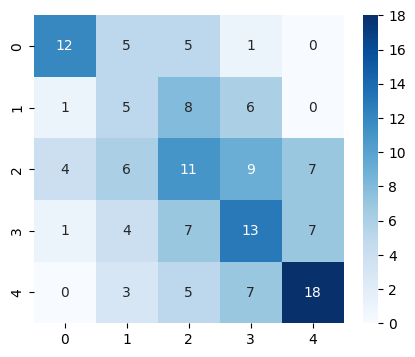

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

target = "18. How often do you feel depressed or down?"
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
wellness_scaled = scaler.fit_transform(df_encoded.drop(columns=[target]))

wellness_df = pd.DataFrame(wellness_scaled, columns=[f"Q{i+1}" for i in range(wellness_scaled.shape[1])])
wellness_df['Wellness_Score'] = (1 - wellness_df.mean(axis=1))*100  # map 0-100

def wellness_category(score):
    if score >= 75:
        return "High"
    elif score >= 50:
        return "Moderate"
    else:
        return "Low"

wellness_df['Wellness_Level'] = wellness_df['Wellness_Score'].apply(wellness_category)


In [ ]:
# Add model predictions
df['Predicted_Depression_Level'] = model.predict(df_encoded.drop(columns=[target]))

# Add wellness scores
df['Wellness_Score'] = wellness_df['Wellness_Score']
df['Wellness_Level'] = wellness_df['Wellness_Level']

df_fused = df[['Predicted_Depression_Level', 'Wellness_Score', 'Wellness_Level']]
df_fused.head()


,Predicted_Depression_Level,Wellness_Score,Wellness_Level
0,1,41.666667,Low
1,4,38.888889,Low
2,3,52.777778,Moderate
3,4,55.555556,Moderate
4,3,36.111111,Low


In [ ]:
import praw  # Reddit
import tweepy  # X (Twitter)

# --- Reddit API setup ---
reddit = praw.Reddit(
    client_id='WcD6YWENTV2wbntiyHDJVQ',
    client_secret='YSZBw9FaHjxcQoVZc3ypFFZQrsMsaw',
    user_agent='mental_wellness_app'
)

# --- X API setup ---
bearer_token = 'AAAAAAAAAAAAAAAAAAAAABv%2F4AEAAAAAFR%2FFyGHIJK2C%2F5Fdc25erIMToDE%3DGmo2RGro5RmKbdOTgLnydGAIowuFuk07AShmfr7f9Xs8fAohXe'
client_x = tweepy.Client(bearer_token=bearer_token)

def fetch_user_posts(platform, username, limit=10):
    posts = []

    if platform == "Reddit":
        try:
            user = reddit.redditor(username)
            for post in user.submissions.new(limit=limit):
                posts.append(post.title + " " + post.selftext)

            if len(posts) == 0:
                posts.append("No posts found for this Reddit username.")
        except Exception as e:
            posts.append(f"Invalid Reddit username or error: {str(e)}")

    elif platform == "X":
        try:
            # Step 1: fetch user ID from username
            user_resp = client_x.get_user(username=username)
            if user_resp.data is None:
                posts.append("Invalid X username.")
            else:
                user_id = user_resp.data.id
                # Step 2: fetch tweets
                tweets_resp = client_x.get_users_tweets(id=user_id, max_results=limit)
                if tweets_resp.data:
                    for t in tweets_resp.data:
                        posts.append(t.text)
                else:
                    posts.append("No tweets found for this X username.")
        except Exception as e:
            posts.append(f"Error fetching X posts: {str(e)}")

    else:
        posts.append("Invalid platform selected.")

    return posts


In [ ]:
def analyze_posts(posts):
    # Check if posts are valid
    if not posts or all("No posts found" in p or "Invalid" in p or "Error" in p for p in posts):
        return None, None, "Invalid Username / No Posts Found"

    # Otherwise, do normal word-based analysis
    text = " ".join(posts).lower()
    depression_score = 0
    if "sad" in text or "depressed" in text:
        depression_score += 3
    if "happy" in text or "good" in text:
        depression_score -= 1

    # Clamp 0-5
    depression_score = max(0, min(5, depression_score))

    # Map to wellness score (0-100)
    wellness_score = 100 - depression_score*10
    if wellness_score >= 75:
        category = "High"
    elif wellness_score >= 50:
        category = "Moderate"
    else:
        category = "Low"

    return depression_score, wellness_score, category


In [ ]:
# -----------------------------
# Colab-ready Flask + ngrok code
# -----------------------------

from flask import Flask, request, render_template_string
from pyngrok import ngrok, conf
import praw
import tweepy

# --- Ngrok config ---
ngrok.set_auth_token("32q45HwIv3L5s2eWKPRtnWAyRag_5jmhuqEVtxeX8fnNjBdDD")
conf.get_default().region = "in"
tunnel = ngrok.connect(5000)
print("Ngrok URL:", tunnel.public_url)

# --- Flask app ---
app = Flask(__name__)

# --- Reddit API setup (replace with your credentials) ---
reddit = praw.Reddit(
    client_id='YOUR_REDDIT_CLIENT_ID',
    client_secret='YOUR_REDDIT_CLIENT_SECRET',
    user_agent='mental_wellness_app'
)

# --- X API setup (replace with your credentials) ---
bearer_token = 'YOUR_X_BEARER_TOKEN'
client_x = tweepy.Client(bearer_token=bearer_token)

# --- Fetch user posts function ---
def fetch_user_posts(platform, username, limit=10):
    posts = []

    if platform == "Reddit":
        try:
            user = reddit.redditor(username)
            for post in user.submissions.new(limit=limit):
                posts.append(post.title + " " + post.selftext)
            if len(posts) == 0:
                posts.append("No posts found for this Reddit username.")
        except Exception as e:
            posts.append(f"Invalid Reddit username or error: {str(e)}")

    elif platform == "X":
        try:
            # Step 1: fetch user ID from username
            user_resp = client_x.get_user(username=username)
            if user_resp.data is None:
                posts.append("Invalid X username.")
            else:
                user_id = user_resp.data.id
                # Step 2: fetch tweets
                tweets_resp = client_x.get_users_tweets(id=user_id, max_results=limit)
                if tweets_resp.data:
                    for t in tweets_resp.data:
                        posts.append(t.text)
                else:
                    posts.append("No tweets found for this X username.")
        except Exception as e:
            posts.append(f"Error fetching X posts: {str(e)}")
    else:
        posts.append("Invalid platform selected.")

    # Debug print to check fetched posts
    print("DEBUG: Fetched posts =", posts)
    return posts

# --- Analyze posts function ---
def analyze_posts(posts):
    # Check if posts are valid
    if not posts or all("No posts found" in p or "Invalid" in p or "Error" in p for p in posts):
        return None, None, "Invalid Username / No Posts Found"

    # Normal analysis
    text = " ".join(posts).lower()
    depression_score = 0
    if "sad" in text or "depressed" in text:
        depression_score += 3
    if "happy" in text or "good" in text:
        depression_score -= 1

    depression_score = max(0, min(5, depression_score))

    wellness_score = 100 - depression_score*10
    if wellness_score >= 75:
        category = "High"
    elif wellness_score >= 50:
        category = "Moderate"
    else:
        category = "Low"

    return depression_score, wellness_score, category

# --- Flask template ---
template = """
<!doctype html>
<title>Mental Wellness Detection</title>
<h2>Mental Wellness Detection</h2>
<form method=post>
  <label>Select Platform:</label>
  <select name="platform">
    <option value="Reddit">Reddit</option>
    <option value="X">X</option>
  </select><br><br>
  <label>Enter Username:</label>
  <input type=text name=username required>
  <input type=submit value=Submit>
</form>
{% if report %}
<h3>Wellness Report</h3>
<div style="line-height:1.6;">
{{ report|safe }}
</div>
{% endif %}
"""

# --- Flask route ---
@app.route("/", methods=["GET", "POST"])
def home_page():  # function name changed to avoid AssertionError
    report = ""
    if request.method == "POST":
        platform = request.form["platform"]
        username = request.form["username"]

        posts = fetch_user_posts(platform, username)
        depression_level, wellness_score, category = analyze_posts(posts)

        if category == "Invalid Username / No Posts Found":
            report = f"<p>⚠️ {category}. Please check the username and try again.</p>"
        else:
            report_lines = [
                f"<p><strong>Platform:</strong> {platform}</p>",
                f"<p><strong>Username:</strong> {username}</p>",
                f"<p><strong>Predicted Depression Level:</strong> {depression_level}</p>",
                f"<p><strong>Wellness Score:</strong> {wellness_score}/100</p>",
                f"<p><strong>Category:</strong> {category}</p>"
            ]
            if category == "High":
                report_lines.append("<p>✅ You are doing great! Keep positive habits.</p>")
            elif category == "Moderate":
                report_lines.append("<p>⚠️ Wellness moderate. Some improvement needed.</p>")
            else:
                report_lines.append("<p>🚨 Low wellness detected. Seek support if needed.</p>")

            report = "\n".join(report_lines)

    return render_template_string(template, report=report)

# --- Run Flask app ---
app.run()


Ngrok URL: https://d6b991be5b39.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [25/Sep/2025 07:30:44] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Sep/2025 07:30:44] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [25/Sep/2025 07:30:49] "POST / HTTP/1.1" 200 -


DEBUG: Fetched posts = ['Error fetching X posts: 401 Unauthorized\nUnauthorized']


INFO:werkzeug:127.0.0.1 - - [25/Sep/2025 07:30:55] "POST / HTTP/1.1" 200 -


DEBUG: Fetched posts = ['Invalid Reddit username or error: received 401 HTTP response']


INFO:werkzeug:127.0.0.1 - - [25/Sep/2025 07:31:03] "POST / HTTP/1.1" 200 -


DEBUG: Fetched posts = ['Error fetching X posts: 401 Unauthorized\nUnauthorized']


INFO:werkzeug:127.0.0.1 - - [25/Sep/2025 07:31:12] "POST / HTTP/1.1" 200 -


DEBUG: Fetched posts = ['Error fetching X posts: 401 Unauthorized\nUnauthorized']
